In [1]:
# Import libraries
import pandas as pd
import numpy as np
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import skew 
from scipy.stats import kurtosis 

In [43]:
file_path = "data/sugar_firm_data.xlsx"
# Define data types for columns
dtype_mapping = {
    'firm': str, 
    'province': str, 
    'year': int, 
    'day_mill': int, 
    'cane_ub': float, 
    'cane_b': float,
    'cane_total': float, 
    'ccs': float, 
    'sugar_w': float, 
    'sugar_p': float, 
    'sugar_total': float, 
    'raws_bulk': float,
    'raws_ks': float, 
    'raws_total': float, 
    'sugar_oth': float, 
    'sugar_all': float, 
    'sugar_yield': float,
    'molass': float, 
    'molass_yield': float
}
# Read the Excel file with specified data types
df = pd.read_excel(file_path, sheet_name="Sheet3", header=0, dtype=dtype_mapping)

# Add policies dummy variables
years_to_include = [2013, 2014, 2015, 2017]
df['160tb'] = df['year'].isin(years_to_include).astype(int)
df['50tb'] = (df['year'].between(2018, 2020)).astype(int)
df['120tb'] = (df['year'].between(2021, 2022)).astype(int)

# Calculate the share of burned sugarcane
df['share_b'] = df['cane_b'] / df['cane_total'] * 100
df['share_ub'] = df['cane_ub'] / df['cane_total'] * 100

# Assuming df is your DataFrame
# Group by 'year' and calculate the sum of 'cane_total'
cane_total_year = df.groupby('year')['cane_total'].sum()

# Merge the summed cane_total values back to the original DataFrame
df = pd.merge(df, cane_total_year, left_on='year', right_index=True, suffixes=('', '_sum_cane_total'))

# Rename the new column for clarity
df.rename(columns={'cane_total_sum_cane_total': 'cane_total_year'}, inplace=True)



# Group by 'province' and 'year', and calculate the sum of 'cane_total'
province_year_cane_total = df.groupby(['province', 'year'])['cane_total'].sum().reset_index()

# Merge the result back into the original DataFrame 'df'
df = pd.merge(df, province_year_cane_total, on=['province', 'year'], suffixes=('', '_prov'))

# merge initial price to the df
df_price = pd.read_excel("data/sugar_price.xlsx")
df_price.dtypes
df = pd.merge(df, df_price[['year', 'ini_price']], on='year', how='left')

#calculate initial price include ccs
df['ini_price_ccs'] = (df['ini_price'] * 0.6 / 10) * (df['ccs'] - 10) + df['ini_price']


In [10]:
df.describe()

,year,day_mill,cane_ub,cane_b,cane_total,ccs,sugar_w,sugar_p,sugar_total,raws_bulk,...,molass_yield,160tb,50tb,120tb,share_b,share_ub,cane_total_year,cane_total_prov,ini_price,ini_price_ccs
count,1051.000000,1051.000000,1.051000e+03,1.051000e+03,1.051000e+03,1051.000000,1.050000e+03,1.049000e+03,1.051000e+03,1051.000000,...,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1.051000e+03,1.051000e+03,1051.000000,1051.000000
mean,2012.516651,120.861085,7.340976e+05,9.676059e+05,1.701703e+06,12.093306,2.965521e+05,3.315395e+05,6.271785e+05,112755.862951,...,44.009099,0.196004,0.160799,0.108468,55.241829,44.758171,8.617245e+07,4.200179e+06,837.655566,944.860123
std,6.095624,29.714478,6.033397e+05,8.388150e+05,1.185142e+06,0.930575,2.717406e+05,3.716783e+05,4.731862e+05,104298.357010,...,5.248310,0.397160,0.367521,0.311119,22.057485,22.057485,2.313759e+07,3.020400e+06,169.509057,205.121932
min,2002.000000,22.000000,1.561349e+04,8.605300e+03,2.648928e+04,9.790978,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,26.331407,0.000000,0.000000,0.000000,1.473327,3.686879,4.668972e+07,2.648928e+04,465.000000,476.997000
25%,2007.000000,100.000000,3.174437e+05,3.607511e+05,8.696616e+05,11.400000,1.170354e+05,0.000000e+00,2.971648e+05,31606.031000,...,40.558422,0.000000,0.000000,0.000000,40.372221,27.287119,6.665881e+07,1.623734e+06,750.000000,835.940711
50%,2013.000000,117.000000,5.759144e+05,7.255534e+05,1.366833e+06,12.045063,2.353840e+05,2.400290e+05,5.515735e+05,81528.053000,...,43.770656,0.000000,0.000000,0.000000,59.616876,40.383124,9.207067e+07,3.424766e+06,855.000000,978.633000
75%,2018.000000,138.000000,9.527186e+05,1.322574e+06,2.321452e+06,12.718058,4.049283e+05,5.107100e+05,8.825831e+05,158783.343000,...,46.914459,0.000000,0.000000,0.000000,72.712881,59.627779,9.797969e+07,6.577060e+06,950.000000,1081.603245
max,2022.000000,276.000000,3.819377e+06,5.610617e+06,7.265671e+06,14.810000,2.465218e+06,2.095360e+06,3.093715e+06,630629.940000,...,66.601521,1.000000,1.000000,1.000000,96.313121,98.526673,1.349293e+08,1.222936e+07,1080.000000,1348.272000


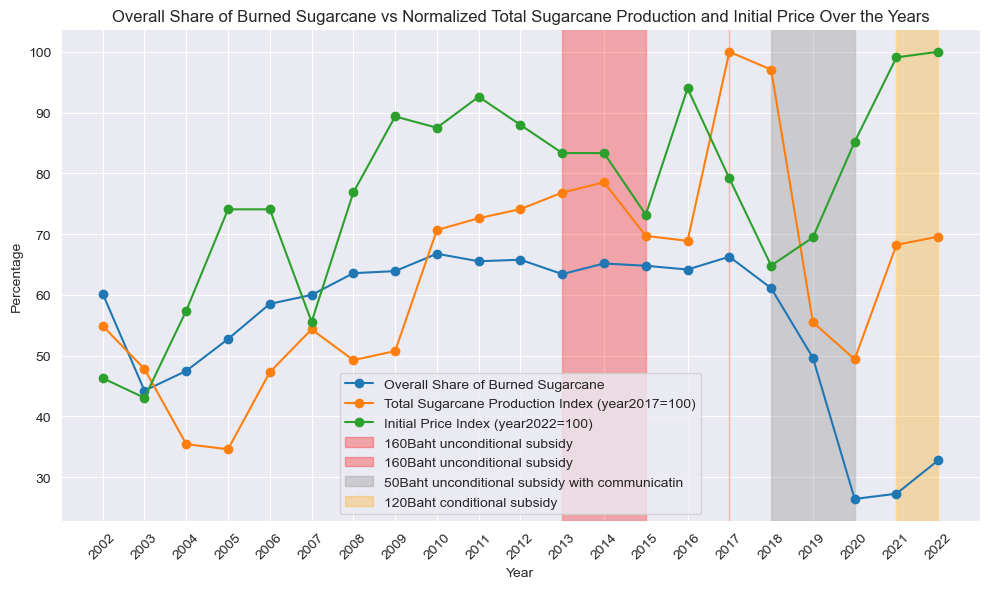

In [3]:
# Calculate the overall share of burned sugarcane across all provinces for each year
overall_share = df.groupby('year').apply(lambda x: (x['cane_b'].sum() / x['cane_total'].sum()) * 100)

# calculate price include sweetness
ini_price = df.groupby('year')['ini_price'].mean()
ini_price_normalized = ini_price / ini_price.loc[2022] * 100

# Calculate the normalized total sugarcane production for each year (scaled by year 2017)
total_cane_production = df.groupby('year')['cane_total'].sum()
total_cane_production_normalized = total_cane_production / total_cane_production.loc[2017] * 100

# Plot the overall share of burned sugarcane and normalized total sugarcane production over the years
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(overall_share.index, overall_share.values, marker='o', label='Overall Share of Burned Sugarcane')
plt.plot(total_cane_production_normalized.index, total_cane_production_normalized.values, marker='o', label='Total Sugarcane Production Index (year2017=100)')
plt.plot(ini_price_normalized.index, ini_price_normalized.values, marker='o', label='Initial Price Index (year2022=100)')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Overall Share of Burned Sugarcane vs Normalized Total Sugarcane Production and Initial Price Over the Years')
plt.grid(True)

# Set x-axis tick locations with integer values
plt.xticks(overall_share.index.astype(int), rotation=45)  # Rotate x-axis labels for better readability

# Highlight regions
plt.axvspan(2013, 2015, color='red', alpha=0.3, label='160Baht unconditional subsidy')
plt.axvspan(2017, 2017, color='red', alpha=0.3, label='160Baht unconditional subsidy')
plt.axvspan(2018, 2020, color='gray', alpha=0.3, label='50Baht unconditional subsidy with communicatin')
plt.axvspan(2021, 2022, color='orange', alpha=0.3, label='120Baht conditional subsidy')

plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Save the figure as an image file (e.g., PNG)
plt.savefig('figure/share_burned_sugar_total.png')
plt.show()

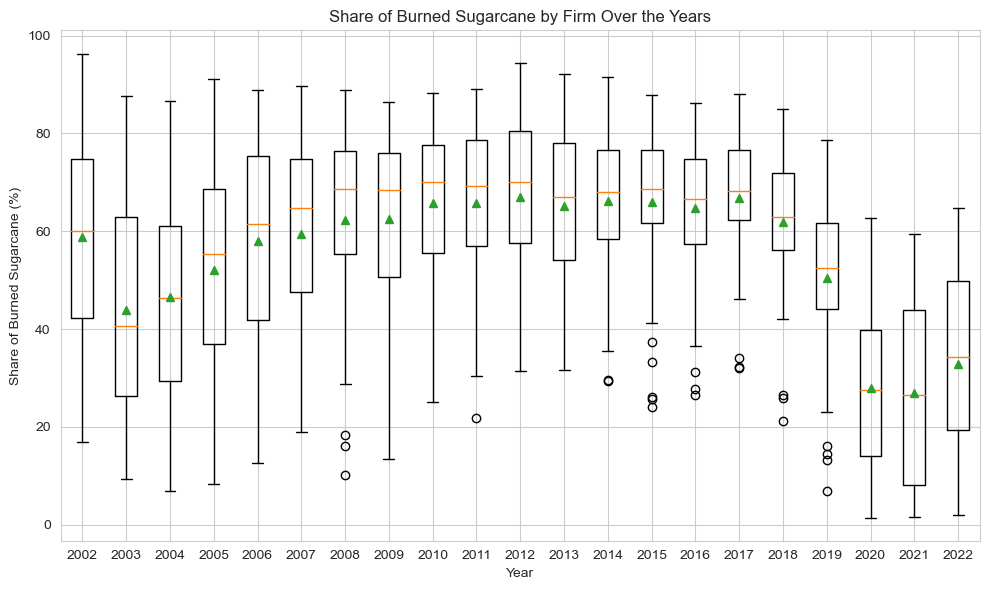

In [27]:
# Create a dictionary to store data for each year
data_dict = {}

# Group data by year
grouped_by_year = df.groupby('year')

# Populate the data dictionary with share_b values for each year
for year, data in grouped_by_year:
    data_dict[year] = data['share_b']

# Convert the dictionary to a list of values (for plotting)
data_values = list(data_dict.values())

# Create a box plot
plt.figure(figsize=(10, 6))  # Set the figure size
plt.boxplot(data_values, labels=data_dict.keys(), showmeans=True)

plt.xlabel('Year')
plt.ylabel('Share of Burned Sugarcane (%)')
plt.title('Share of Burned Sugarcane by Firm Over the Years')
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('figure/yearly_burn_bosplot.png')
plt.show()


In [4]:
# Filter the DataFrame to include only the observations between 2015 and 2022
filtered_data = df[(df['year'] >= 2014) & (df['year'] <= 2022)]

# Count the number of observations for each firm
firm_counts = filtered_data.groupby('firm').size()

# Get the firms with a count of 8 observations
firms_with_eight_observations = firm_counts[firm_counts == 9].index

# Filter the DataFrame to include only the selected firms
df2015 = filtered_data[filtered_data['firm'].isin(firms_with_eight_observations)]

# Display the resulting DataFram
df2015

,firm,province,year,day_mill,cane_ub,cane_b,cane_total,ccs,sugar_w,sugar_p,...,molass_yield,160tb,50tb,120tb,share_b,share_ub,cane_total_year,cane_total_prov,ini_price,ini_price_ccs
330,Baanrai Sugar Industry,Uthaithani,2014,106,609457.23,2387408.31,2996865.54,10.960855,132119.00,505877.00,...,41.868802,1,0,0,79.663511,20.336489,1.059591e+08,2996865.54,900.0,951.886154
331,Ban Pong Sugar,Ratchaburi,2014,99,434196.31,635689.63,1069885.94,11.549160,106301.00,641431.50,...,39.158370,1,0,0,59.416579,40.583421,1.059591e+08,2326677.16,900.0,983.654647
332,Ratchaburi Sugar Factory,Ratchaburi,2014,108,886428.12,370363.10,1256791.22,12.036754,196679.00,427909.00,...,42.212859,1,0,0,29.468944,70.531056,1.059591e+08,2326677.16,900.0,1009.984715
333,Buriram Sugar Factory,Buriram,2014,160,629832.44,1321414.68,1951247.12,13.480000,367900.75,0.00,...,40.495424,1,0,0,67.721544,32.278456,1.059591e+08,1951247.12,900.0,1087.920000
334,CHAIMONGKOL REFINED SUGAR,Suphan Buri,2014,92,202653.15,611388.70,814041.85,10.950784,192042.00,75950.00,...,47.594580,1,0,0,75.105316,24.894684,1.059591e+08,5618578.51,900.0,951.342357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,SURIN SUGAR,Surin,2022,111,1341011.07,286295.71,1627306.78,13.650000,7470.00,798766.26,...,33.550260,0,0,1,17.593223,82.406777,9.388788e+07,1627306.78,1080.0,1316.520000
817,THAI IDENTITY SUGAR FACTORY,Uttaradit,2022,109,1590894.98,55139.38,1646034.36,13.350000,42404.00,244724.50,...,34.793320,0,0,1,3.349832,96.650168,9.388788e+07,1646034.36,1080.0,1297.080000
819,TRR,Petchabun,2022,104,1907753.01,2253819.59,4161572.60,13.590000,266526.50,360149.00,...,34.273188,0,0,1,54.157882,45.842118,9.388788e+07,5386255.77,1080.0,1312.632000
820,Thip Sukhothai,Sukhothai,2022,105,1891097.31,66971.47,1958068.78,13.330000,13426.50,63984.00,...,36.203297,0,0,1,3.420282,96.579718,9.388788e+07,1958068.78,1080.0,1295.784000


Bandwidth = 1
                            OLS Regression Results                            
Dep. Variable:                share_b   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     15.81
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           6.22e-07
Time:                        00:08:01   Log-Likelihood:                -603.85
No. Observations:                 147   AIC:                             1214.
Df Residuals:                     144   BIC:                             1223.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
constant             0.136

C:\Users\jeng_\AppData\Local\Temp\ipykernel_3076\3312137385.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2015['discontinue2018'] = df2015['year'].apply(lambda x: 1 if x >= 2018 else 0)
C:\Users\jeng_\AppData\Local\Temp\ipykernel_3076\3312137385.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2015['discontinue2021'] = df2015['year'].apply(lambda x: 1 if x >= 2021 else 0)
C:\Users\jeng_\AppData\Local\Temp\ipykernel_3076\3312137385.py:15: SettingWithCopyWarning: 
A value is trying to be set on 

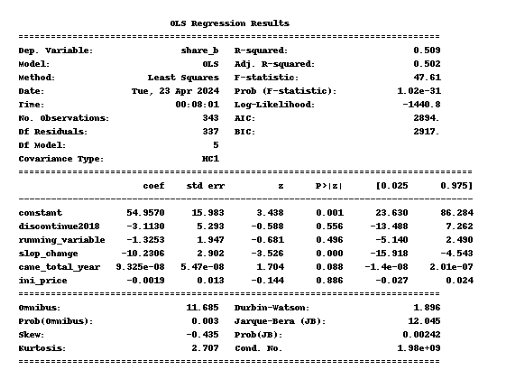

In [41]:
import pandas as pd
import statsmodels.api as sm
# Now, open the text file and take a screenshot to save it as an image, or use other methods to convert text to image.
# For example, you can use libraries like PIL to create an image from text.
# Here's a basic example using PIL:
from PIL import Image, ImageDraw, ImageFont

# Generate dummy variable 'discontinue2018'
df2015['discontinue2018'] = df2015['year'].apply(lambda x: 1 if x >= 2018 else 0)

# Generate dummy variable 'discontinue2021'
df2015['discontinue2021'] = df2015['year'].apply(lambda x: 1 if x >= 2021 else 0)

# Add constant term
df2015['constant'] = 1

# Create shifted 'psu' variable
df2015['running_variable'] = df2015['year'] - 2018

# Create interaction term
df2015['slop_change'] = df2015['running_variable'] * df2015['discontinue2018']

# ini price include ccs
df2015['ini_price_ccs'] = (df2015['ini_price'] * 0.6 / 10) * (df2015['ccs'] - 10) + df2015['ini_price']

# Define bandwidth values
bandwidth_values = [1, 2, 3]

for n in bandwidth_values:
    print(f"Bandwidth = {n}")
    
    # Select bandwidth
    df2015_band = df2015[(df2015['running_variable'] >= -n) & (df2015['running_variable'] <= n)]

    # Define independent variables
    X = df2015_band[['constant', 'discontinue2018', 'running_variable', 'slop_change', 'cane_total_year', 'ini_price']]

    # Define dependent variable
    y = df2015_band['share_b']

    # Drop missing values
    X = X.dropna()
    y = y[X.index]

    # Fit the regression model
    model = sm.OLS(y, X).fit(cov_type='HC1')

    # Print regression results
    print(model.summary())
    print("\n")
    # Import necessary libraries

    # Define the filename for saving the model summary as text
    text_filename = "model_summary.txt"

    # Save the model summary as text
    with open(text_filename, "w") as text_file: text_file.write(model.summary().as_text())


    # Open the text file and read its contents
    with open(text_filename, "r") as text_file: text_content = text_file.read()

    # Define font size and image size
    font_size = 12
    image_width = 550
    image_height = 400

    # Create a new image with a white background
    image = Image.new("RGB", (image_width, image_height), "white")
    draw = ImageDraw.Draw(image)

    # Load a font
    font = ImageFont.load_default()

    # Draw text on the image
    draw.text((10, 10), text_content, fill="black", font=font)

    # Save the image
    image.save(f"figure/final_model_summary_Bandwidth = {n}.png")

# Display or further process the image as needed
plt.imshow(image)
plt.axis("off")
plt.show()


                            OLS Regression Results                            
Dep. Variable:                share_b   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     47.61
Date:                Mon, 22 Apr 2024   Prob (F-statistic):           1.02e-31
Time:                        23:57:27   Log-Likelihood:                -1440.8
No. Observations:                 343   AIC:                             2894.
Df Residuals:                     337   BIC:                             2917.
Df Model:                           5                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
constant            54.9570     15.983  

C:\Users\jeng_\AppData\Local\Temp\ipykernel_3076\455719925.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2015['discontinue2018'] = df2015['year'].apply(lambda x: 1 if x >= 2018 else 0)
C:\Users\jeng_\AppData\Local\Temp\ipykernel_3076\455719925.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2015['discontinue2021'] = df2015['year'].apply(lambda x: 1 if x >= 2021 else 0)
C:\Users\jeng_\AppData\Local\Temp\ipykernel_3076\455719925.py:13: SettingWithCopyWarning: 
A value is trying to be set on a c

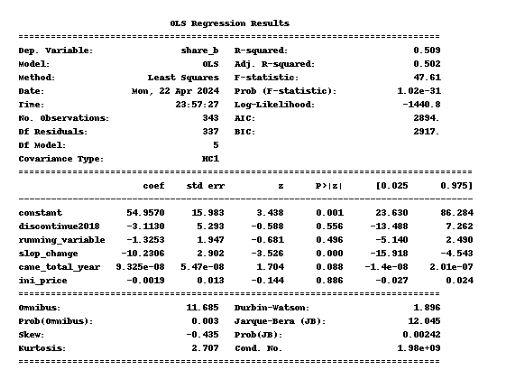

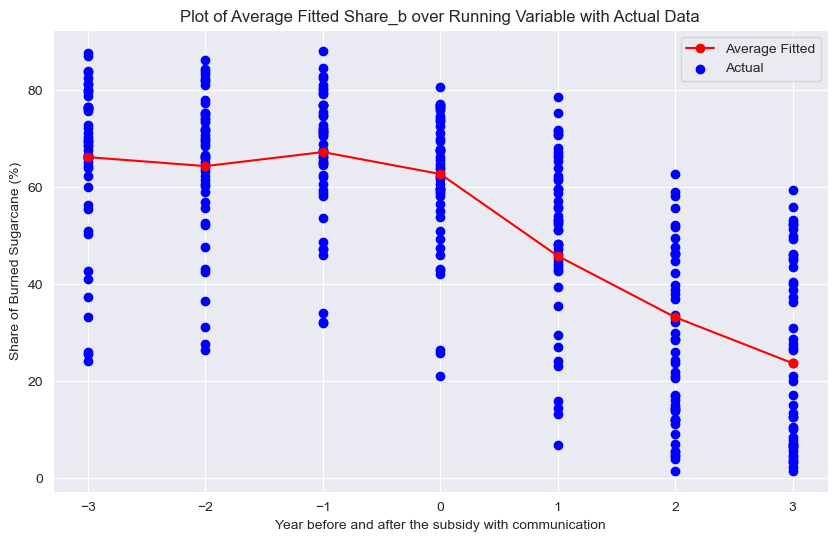

In [33]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Generate dummy variable 'discontinue2018'
df2015['discontinue2018'] = df2015['year'].apply(lambda x: 1 if x >= 2018 else 0)

# Generate dummy variable 'discontinue2021'
df2015['discontinue2021'] = df2015['year'].apply(lambda x: 1 if x >= 2021 else 0)

# Add constant term
df2015['constant'] = 1

# Create shifted 'psu' variable
df2015['running_variable'] = df2015['year'] - 2018

# Create interaction term
df2015['slop_change'] = df2015['running_variable'] * df2015['discontinue2018']

# Select bandwidth
df2015_band = df2015[(df2015['running_variable'] >= -3) & (df2015['running_variable'] <= 3)]

# Define independent variables
X = df2015_band[['constant', 'discontinue2018', 'running_variable', 'slop_change', 'cane_total_year', 'ini_price']]

# Define dependent variable
y = df2015_band['share_b']

# Drop missing values
X = X.dropna()
y = y[X.index]

# Fit the regression model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Get the model summary text
model_summary = model.summary()

# Print regression results
print(model.summary())
print("\n")

# Import necessary libraries
import matplotlib.pyplot as plt

# Define the filename for saving the model summary as text
text_filename = "model_summary.txt"

# Save the model summary as text
with open(text_filename, "w") as text_file:
    text_file.write(model.summary().as_text())

# Now, open the text file and take a screenshot to save it as an image, or use other methods to convert text to image.
# For example, you can use libraries like PIL to create an image from text.
# Here's a basic example using PIL:
from PIL import Image, ImageDraw, ImageFont

# Open the text file and read its contents
with open(text_filename, "r") as text_file:
    text_content = text_file.read()

# Define font size and image size
font_size = 12
image_width = 550
image_height = 400

# Create a new image with a white background
image = Image.new("RGB", (image_width, image_height), "white")
draw = ImageDraw.Draw(image)

# Load a font
font = ImageFont.load_default()

# Draw text on the image
draw.text((10, 10), text_content, fill="black", font=font)

# Save the image
image.save("figure/final_model_summary.png")

# Display or further process the image as needed
plt.imshow(image)
plt.axis("off")
plt.show()

# Calculate the average of each independent variable over the values of the running variable
avg_X_over_running = X.groupby('running_variable').mean()
avg_X_over_running['running_variable'] = avg_X_over_running.index

# Add constant term to avg_X_over_running
avg_X_over_running = avg_X_over_running[['constant', 'discontinue2018', 'running_variable', 'slop_change', 'cane_total_year', 'ini_price']]

# Predict y using the average of X
y_avg_pred = model.predict(avg_X_over_running)

# Plot the average fitted y over the values of the running variable
plt.figure(figsize=(10, 6))
plt.plot(avg_X_over_running.index, y_avg_pred, label='Average Fitted', color='red', marker='o')

# Add scatter plot of actual y
plt.scatter(df2015_band['running_variable'], y, label='Actual', color='blue')

plt.xlabel('Year before and after the subsidy with communication')
plt.ylabel('Share of Burned Sugarcane (%)')
plt.title('Plot of Average Fitted Share_b over Running Variable with Actual Data')
plt.legend()
# Save the figure as an image file (e.g., PNG)
plt.savefig('figure/fitted_burned_sugarcane.png')
plt.show()

In [21]:
correlation_matrix = df2015[['share_b', 'discontinue2018', 'running_variable', 'slop_change', 'cane_total_year', 'ini_price']].corr()
correlation_matrix

,share_b,discontinue2018,running_variable,slop_change,cane_total_year,ini_price
share_b,1.000000,-0.565617,-0.643259,-0.664363,0.422814,-0.399942
discontinue2018,-0.565617,1.000000,0.866025,0.685994,-0.354704,0.053158
running_variable,-0.643259,0.866025,1.000000,0.891133,-0.335496,0.419218
slop_change,-0.664363,0.685994,0.891133,1.000000,-0.447568,0.675112
cane_total_year,0.422814,-0.354704,-0.335496,-0.447568,1.000000,-0.292365
ini_price,-0.399942,0.053158,0.419218,0.675112,-0.292365,1.000000


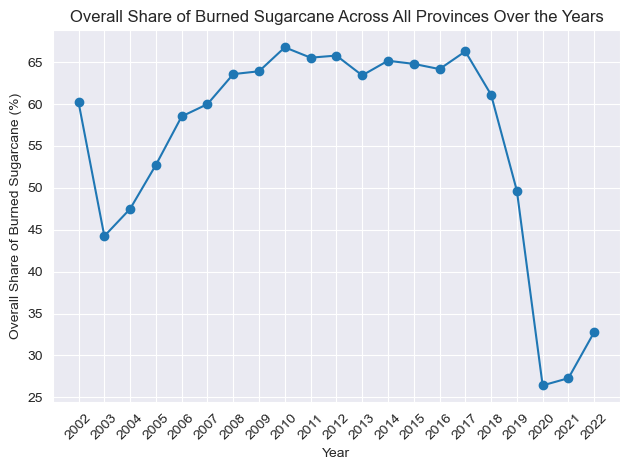

In [6]:
# Calculate the overall share of burned sugarcane across all provinces for each year
overall_share = df.groupby('year').apply(lambda x: (x['cane_b'].sum() / x['cane_total'].sum()) * 100)

# Plot the overall share of burned sugarcane across all provinces over the years
plt.plot(overall_share.index, overall_share.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Overall Share of Burned Sugarcane (%)')
plt.title('Overall Share of Burned Sugarcane Across All Provinces Over the Years')
plt.grid(True)


# Set x-axis tick locations with integer values
plt.xticks(overall_share.index.astype(int), rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

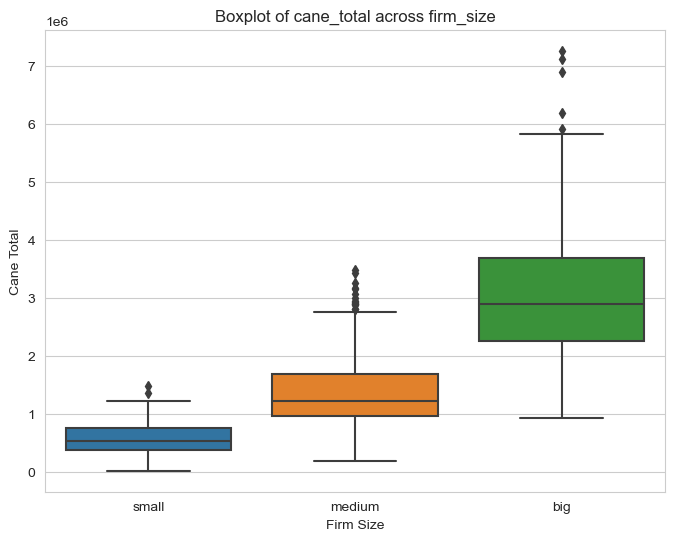

In [25]:
# Calculate the average 'cane_total' for each firm
firm_avg_cane_total = df.groupby('firm')['cane_total'].mean()

# Define the thresholds for classifying firm sizes
threshold_small = firm_avg_cane_total.quantile(2.5/10)  # Bottom 25%
threshold_medium = firm_avg_cane_total.quantile(7.5/10)  # Middle 75%

# Function to classify firm sizes
def classify_firm_size(avg_cane_total):
    if avg_cane_total <= threshold_small:
        return 'small'
    elif avg_cane_total <= threshold_medium:
        return 'medium'
    else:
        return 'big'

# Apply the function to classify firm sizes and create the 'firm_size' column
df['firm_size'] = df['firm'].map(firm_avg_cane_total.apply(classify_firm_size))

import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the seaborn plot
sns.set_style("whitegrid")

# Set the order of the categories
firm_size_order = ['small', 'medium', 'big']

# Plot the boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='firm_size', y='cane_total', data=df, order=firm_size_order)
plt.title('Boxplot of cane_total across firm_size')
plt.xlabel('Firm Size')
plt.ylabel('Cane Total')

plt.savefig('figure/firm_size_boxplot.png')
plt.show()



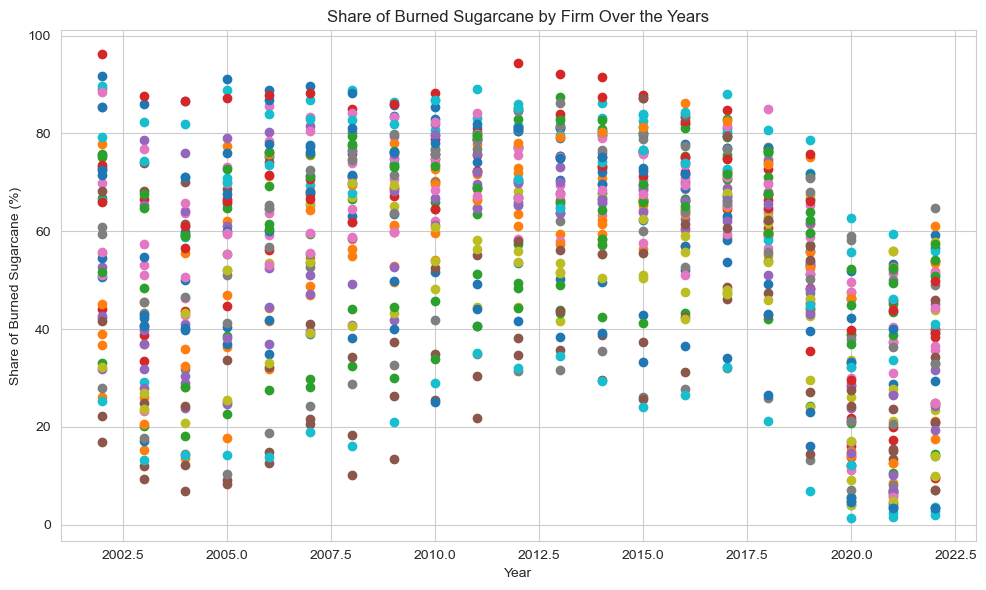

In [11]:

# Scatter plot of firms' share of burned sugarcane against the year
plt.figure(figsize=(10, 6))  # Set the figure size
for firm, data in df.groupby('firm'):
    plt.scatter(data['year'], data['share_b'], label=firm)

plt.xlabel('Year')
plt.ylabel('Share of Burned Sugarcane (%)')
plt.title('Share of Burned Sugarcane by Firm Over the Years')
#plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

C:\Users\jeng_\AppData\Local\Temp\ipykernel_21644\2249890798.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='year', y='share_b', hue='firm_size', data=df, dodge=True, ci=None)


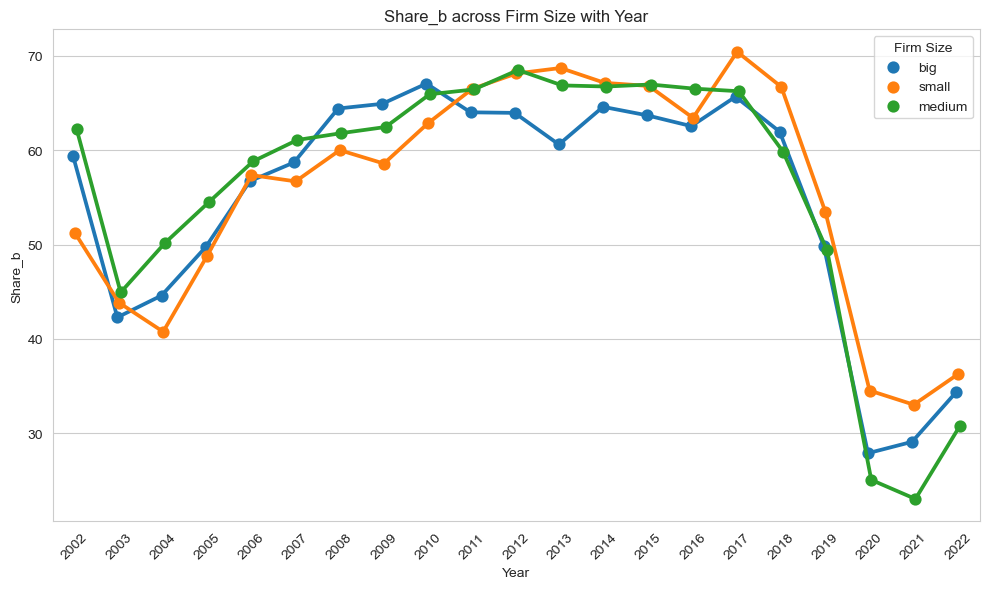

In [26]:
# Set the style of the seaborn plot
sns.set_style("whitegrid")

# Plot the point plot
plt.figure(figsize=(10, 6))
sns.pointplot(x='year', y='share_b', hue='firm_size', data=df, dodge=True, ci=None)
plt.title('Share_b across Firm Size with Year')
plt.xlabel('Year')
plt.ylabel('Share_b')
plt.legend(title='Firm Size')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figure/compare_share_burn_by_size.png')
plt.show()


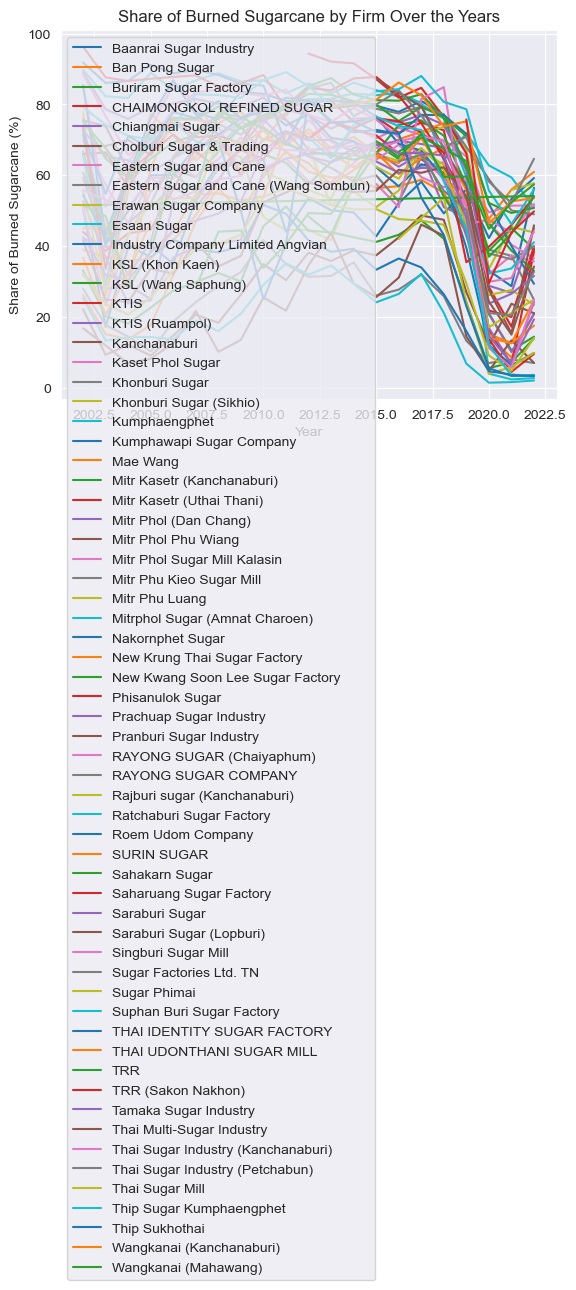

In [4]:
# plot share of burned sugarcane


# Group by firm and plot the share of burned sugarcane over the years
for firm, data in df.groupby('firm'):
    plt.plot(data['year'], data['share_b'], label=firm)

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Share of Burned Sugarcane (%)')
plt.title('Share of Burned Sugarcane by Firm Over the Years')
plt.legend()

# Display the plot
plt.show()

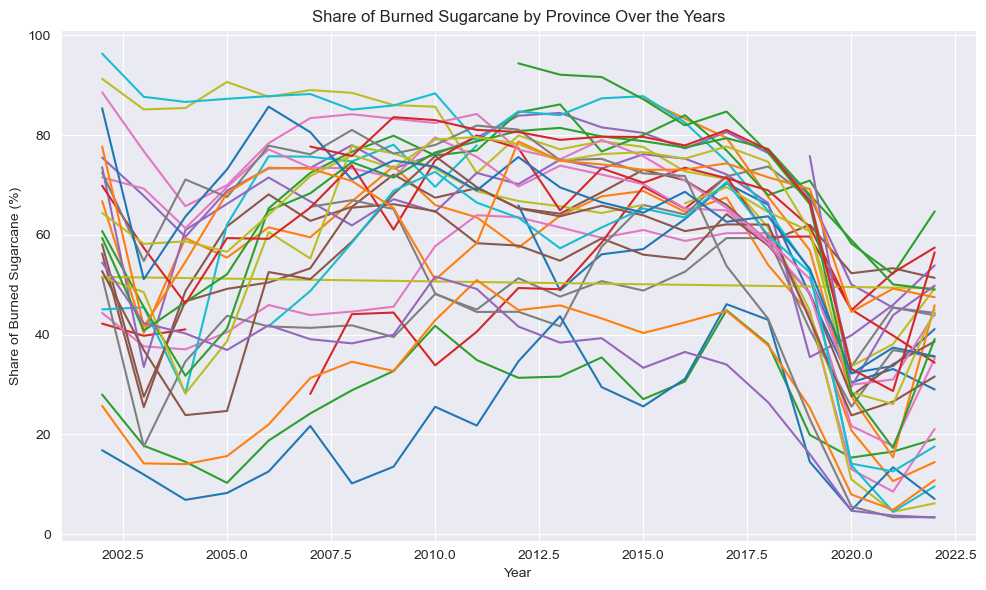

In [5]:
# Calculate the share of burned sugarcane by province
df['share_b_prov'] = df.groupby(['year', 'province'])['cane_b'].transform('sum') / df.groupby(['year', 'province'])['cane_total'].transform('sum') * 100

# Plot the share of burned sugarcane by province
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
for province, data in df.groupby('province'):
    plt.plot(data['year'], data['share_b_prov'], label=province)

plt.xlabel('Year')
plt.ylabel('Share of Burned Sugarcane (%)')
plt.title('Share of Burned Sugarcane by Province Over the Years')
# plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

Normality test results for share_b in Year 2002:
NormaltestResult(statistic=5.196742906302941, pvalue=0.07439463476243864)

Normality test results for cane_total in Year 2002:
NormaltestResult(statistic=6.953852462225605, pvalue=0.030902251578566582)

--------------------------------------------------
Normality test results for share_b in Year 2003:
NormaltestResult(statistic=4.376069343639337, pvalue=0.11213691803895469)

Normality test results for cane_total in Year 2003:
NormaltestResult(statistic=14.294931900335186, pvalue=0.0007868554881010252)

--------------------------------------------------
Normality test results for share_b in Year 2004:
NormaltestResult(statistic=2.9980303662271224, pvalue=0.22335001073653485)

Normality test results for cane_total in Year 2004:
NormaltestResult(statistic=18.47477461455691, pvalue=9.733155575923485e-05)

--------------------------------------------------
Normality test results for share_b in Year 2005:
NormaltestResult(statistic=3.018521003

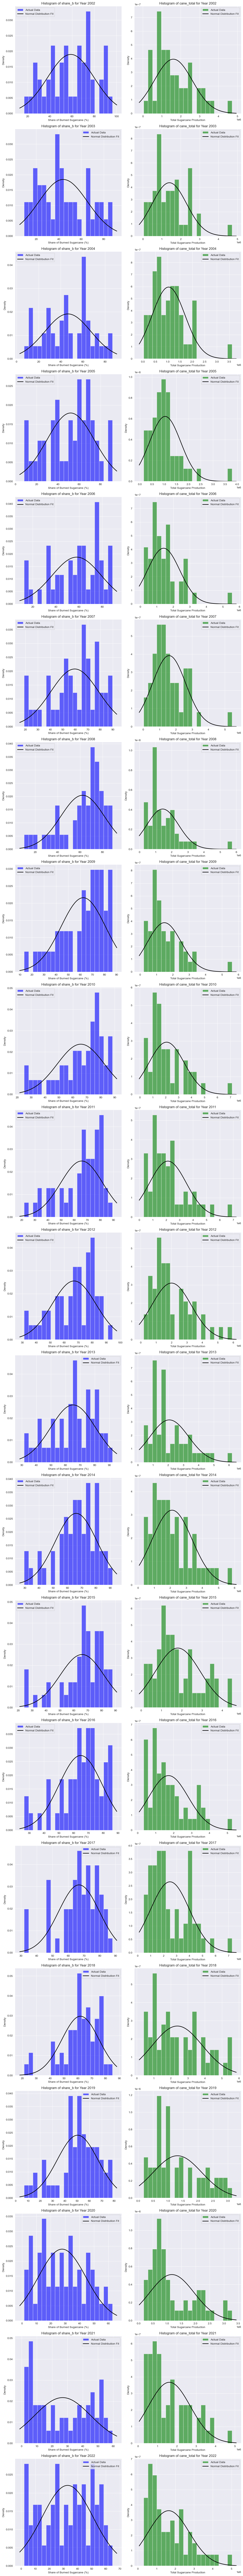

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Assuming df is already defined and contains the necessary data

# Group data by year
grouped_by_year = df.groupby('year')

# Create subplots
fig, axes = plt.subplots(nrows=len(grouped_by_year), ncols=2, figsize=(12, 6 * len(grouped_by_year)))

for i, (year, data) in enumerate(grouped_by_year):
    # Plot histograms of 'share_b' and 'cane_total'
    ax1, ax2 = axes[i]
    
    # Histogram for 'share_b'
    ax1.hist(data['share_b'], bins=20, density=True, alpha=0.6, color='blue', label='Actual Data')
    
    # Fit a normal distribution to 'share_b' data
    mu, sigma = stats.norm.fit(data['share_b'])
    xmin, xmax = ax1.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, sigma)
    ax1.plot(x, p, 'k', linewidth=2, label='Normal Distribution Fit')
    ax1.set_title(f'Histogram of share_b for Year {year}')
    ax1.set_xlabel('Share of Burned Sugarcane (%)')
    ax1.set_ylabel('Density')
    ax1.legend()
    
    # Histogram for 'cane_total'
    ax2.hist(data['cane_total'], bins=20, density=True, alpha=0.6, color='green', label='Actual Data')
    
    # Fit a normal distribution to 'cane_total' data
    mu, sigma = stats.norm.fit(data['cane_total'])
    xmin, xmax = ax2.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, sigma)
    ax2.plot(x, p, 'k', linewidth=2, label='Normal Distribution Fit')
    ax2.set_title(f'Histogram of cane_total for Year {year}')
    ax2.set_xlabel('Total Sugarcane Production')
    ax2.set_ylabel('Density')
    ax2.legend()

    # Perform normality tests
    print(f"Normality test results for share_b in Year {year}:")
    print(stats.normaltest(data['share_b']))
    print(f"\nNormality test results for cane_total in Year {year}:")
    print(stats.normaltest(data['cane_total']))
    print("\n"+"-"*50)

plt.tight_layout()
plt.show()
